In [1]:
import os
import pandas as pd
import yaml
SOL_ROOT = '/home/ddon0001/PhD/experiments/scaled/no_div_constraint'
SCALES_PATH = '/home/ddon0001/PhD/data/cell_tracking_challenge/scales.yaml'

ds_summary = pd.read_csv(f'{SOL_ROOT}/summary.csv')
with open(SCALES_PATH, 'r') as f:
    scales = yaml.safe_load(f)

all_info_df = pd.read_csv(os.path.join(SOL_ROOT, 'all_node_info.csv'))

In [2]:
import numpy as np


all_migrations = all_info_df[all_info_df.first_chosen_neighbour_rank >= 0]
all_migrations['mig_area_prop'] = all_migrations['first_child_area'] / all_migrations['node_area']

/tmp/ipykernel_6245/471187897.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_migrations['mig_area_prop'] = all_migrations['first_child_area'] / all_migrations['node_area']


In [3]:
columns_of_interest = [
    'first_chosen_neighbour_rank',
    'first_child_distance',
    'mig_area_prop',
    'mig_correct'
]

In [4]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [8]:
ds_names = []
accuracies = []
n_div = []
n_train = []
n_test = []
count_skipped = 0
best_models = {}
searches = {}
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    data_df = all_migrations[all_migrations.ds_name == ds_name][columns_of_interest]
    if len(data_df) < 15:
        count_skipped += 1
        continue
    X = data_df.drop(columns=['mig_correct'])
    y = data_df.mig_correct
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    rf = RandomForestClassifier()
    param_dist = {
        'n_estimators': randint(50,500),
        'max_depth': randint(1,20)
    }
    search = RandomizedSearchCV(
        rf,
        param_distributions = param_dist,
        n_iter = 5,
        cv=5
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    best_models[ds_name] = best_model
    searches[ds_name] = search
    
    ds_names.append(ds_name)
    accuracies.append(accuracy)
    n_div.append(len(data_df))
    n_train.append(len(X_train))
    n_test.append(len(X_test))
classifier_df = pd.DataFrame({
    'ds_name': ds_names,
    'accuracy': accuracies,
    'n_div': n_div,
    'n_train': n_train,
    'n_test': n_test
})
print(classifier_df)
print(count_skipped)

/home/ddon0001/miniconda3/envs/trexp/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


                ds_name  accuracy  n_div  n_train  n_test
0   Fluo-C3DL-MDA231_01  0.984375    317      253      64
1   Fluo-C3DL-MDA231_02  0.971698    529      423     106
2    Fluo-N2DH-GOWT1_01  0.997543   2031     1624     407
3    Fluo-N2DH-GOWT1_02  0.980044   2254     1803     451
4      PhC-C2DH-U373_01  1.000000    757      605     152
5      PhC-C2DH-U373_02  0.992647    680      544     136
6     Fluo-N2DL-HeLa_01  0.987574   8448     6758    1690
7     Fluo-N2DL-HeLa_02  0.984372  24952    19961    4991
8      Fluo-C2DL-MSC_01  1.000000    411      328      83
9      Fluo-C2DL-MSC_02  1.000000    176      140      36
10    Fluo-C3DH-H157_01  1.000000    236      188      48
11    Fluo-C3DH-H157_02  0.964286    139      111      28
12     DIC-C2DH-HeLa_01  0.986047   1071      856     215
13     DIC-C2DH-HeLa_02  0.994764    951      760     191
14     Fluo-N3DH-CHO_01  1.000000    853      682     171
15     Fluo-N3DH-CHO_02  1.000000    576      460     116
16      BF-C2D

In [9]:
# check each search for whether we've "converged" on best values
ds_names = []
n_estimators = []
max_depths = []
scores = []
for ds_name, search in searches.items():
    search_results = search.cv_results_
    m_depth = search_results['param_max_depth']
    n_est = search_results['param_n_estimators']
    score = search_results['mean_test_score']

    ds_names.extend([ds_name for _ in range(len(m_depth))])
    n_estimators.extend(n_est)
    max_depths.extend(m_depth)
    scores.extend(score)
search_df = pd.DataFrame({
    'ds_name': ds_names,
    'n_trees': n_estimators,
    'max_depth': max_depths,
    'score': scores
})

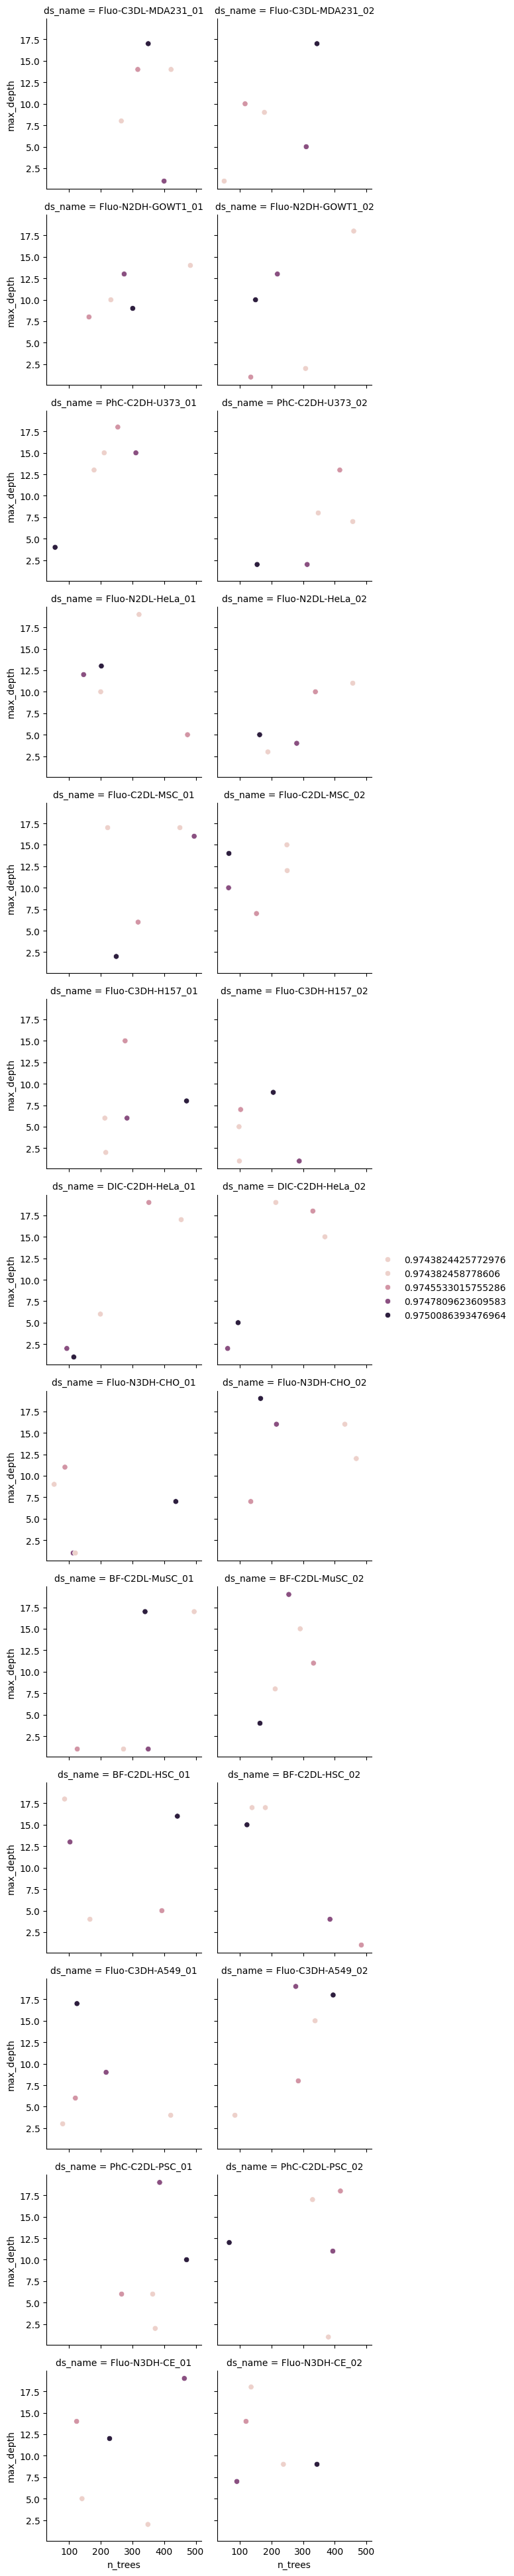

In [10]:
import seaborn as sns

import seaborn as sns

grid = sns.FacetGrid(search_df, col='ds_name', col_wrap=2, sharex=True, sharey=True, legend_out=True)
grid.map_dataframe(sns.scatterplot, x='n_trees', y='max_depth', hue=score)
grid.add_legend()

In [8]:
from sklearn.model_selection import cross_val_score

ds_names = []
average_score = []
std_dev = []
for ds_name, model in best_models.items():
    data_df = all_migrations[all_migrations.ds_name == ds_name][columns_of_interest]
    X = data_df.drop(columns=['mig_correct'])
    y = data_df.mig_correct
    scores = cross_val_score(model, X, y, cv=5)
    ds_names.append(ds_name)
    average_score.append(scores.mean())
    std_dev.append(scores.std())
cross_val_df = pd.DataFrame({
    'ds_name': ds_names,
    'average_score': average_score,
    'std_dev': std_dev
})
cross_val_df

/home/ddon0001/miniconda3/envs/trexp/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/ddon0001/miniconda3/envs/trexp/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,ds_name,average_score,std_dev
0,Fluo-C3DL-MDA231_01,0.987401,0.006301
1,Fluo-C3DL-MDA231_02,0.971644,0.000108
2,Fluo-N2DH-GOWT1_01,0.992614,0.002698
3,Fluo-N2DH-GOWT1_02,0.988909,0.001402
4,PhC-C2DH-U373_01,1.000000,0.000000
5,PhC-C2DH-U373_02,0.988235,0.003602
6,Fluo-N2DL-HeLa_01,0.982363,0.001148
7,Fluo-N2DL-HeLa_02,0.985172,0.000458
8,Fluo-C2DL-MSC_01,1.000000,0.000000
9,Fluo-C2DL-MSC_02,1.000000,0.000000


In [13]:
ds_names = []
feature_names = []
importances = []
for ds_name, model in best_models.items():
    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    for feature_name, importance in feature_importances.items():
        ds_names.append(ds_name)
        feature_names.append(feature_name)
        importances.append(importance)
importance_df = pd.DataFrame({
    'ds_name': ds_names,
    'feature_name': feature_names,
    'importance': importances
})

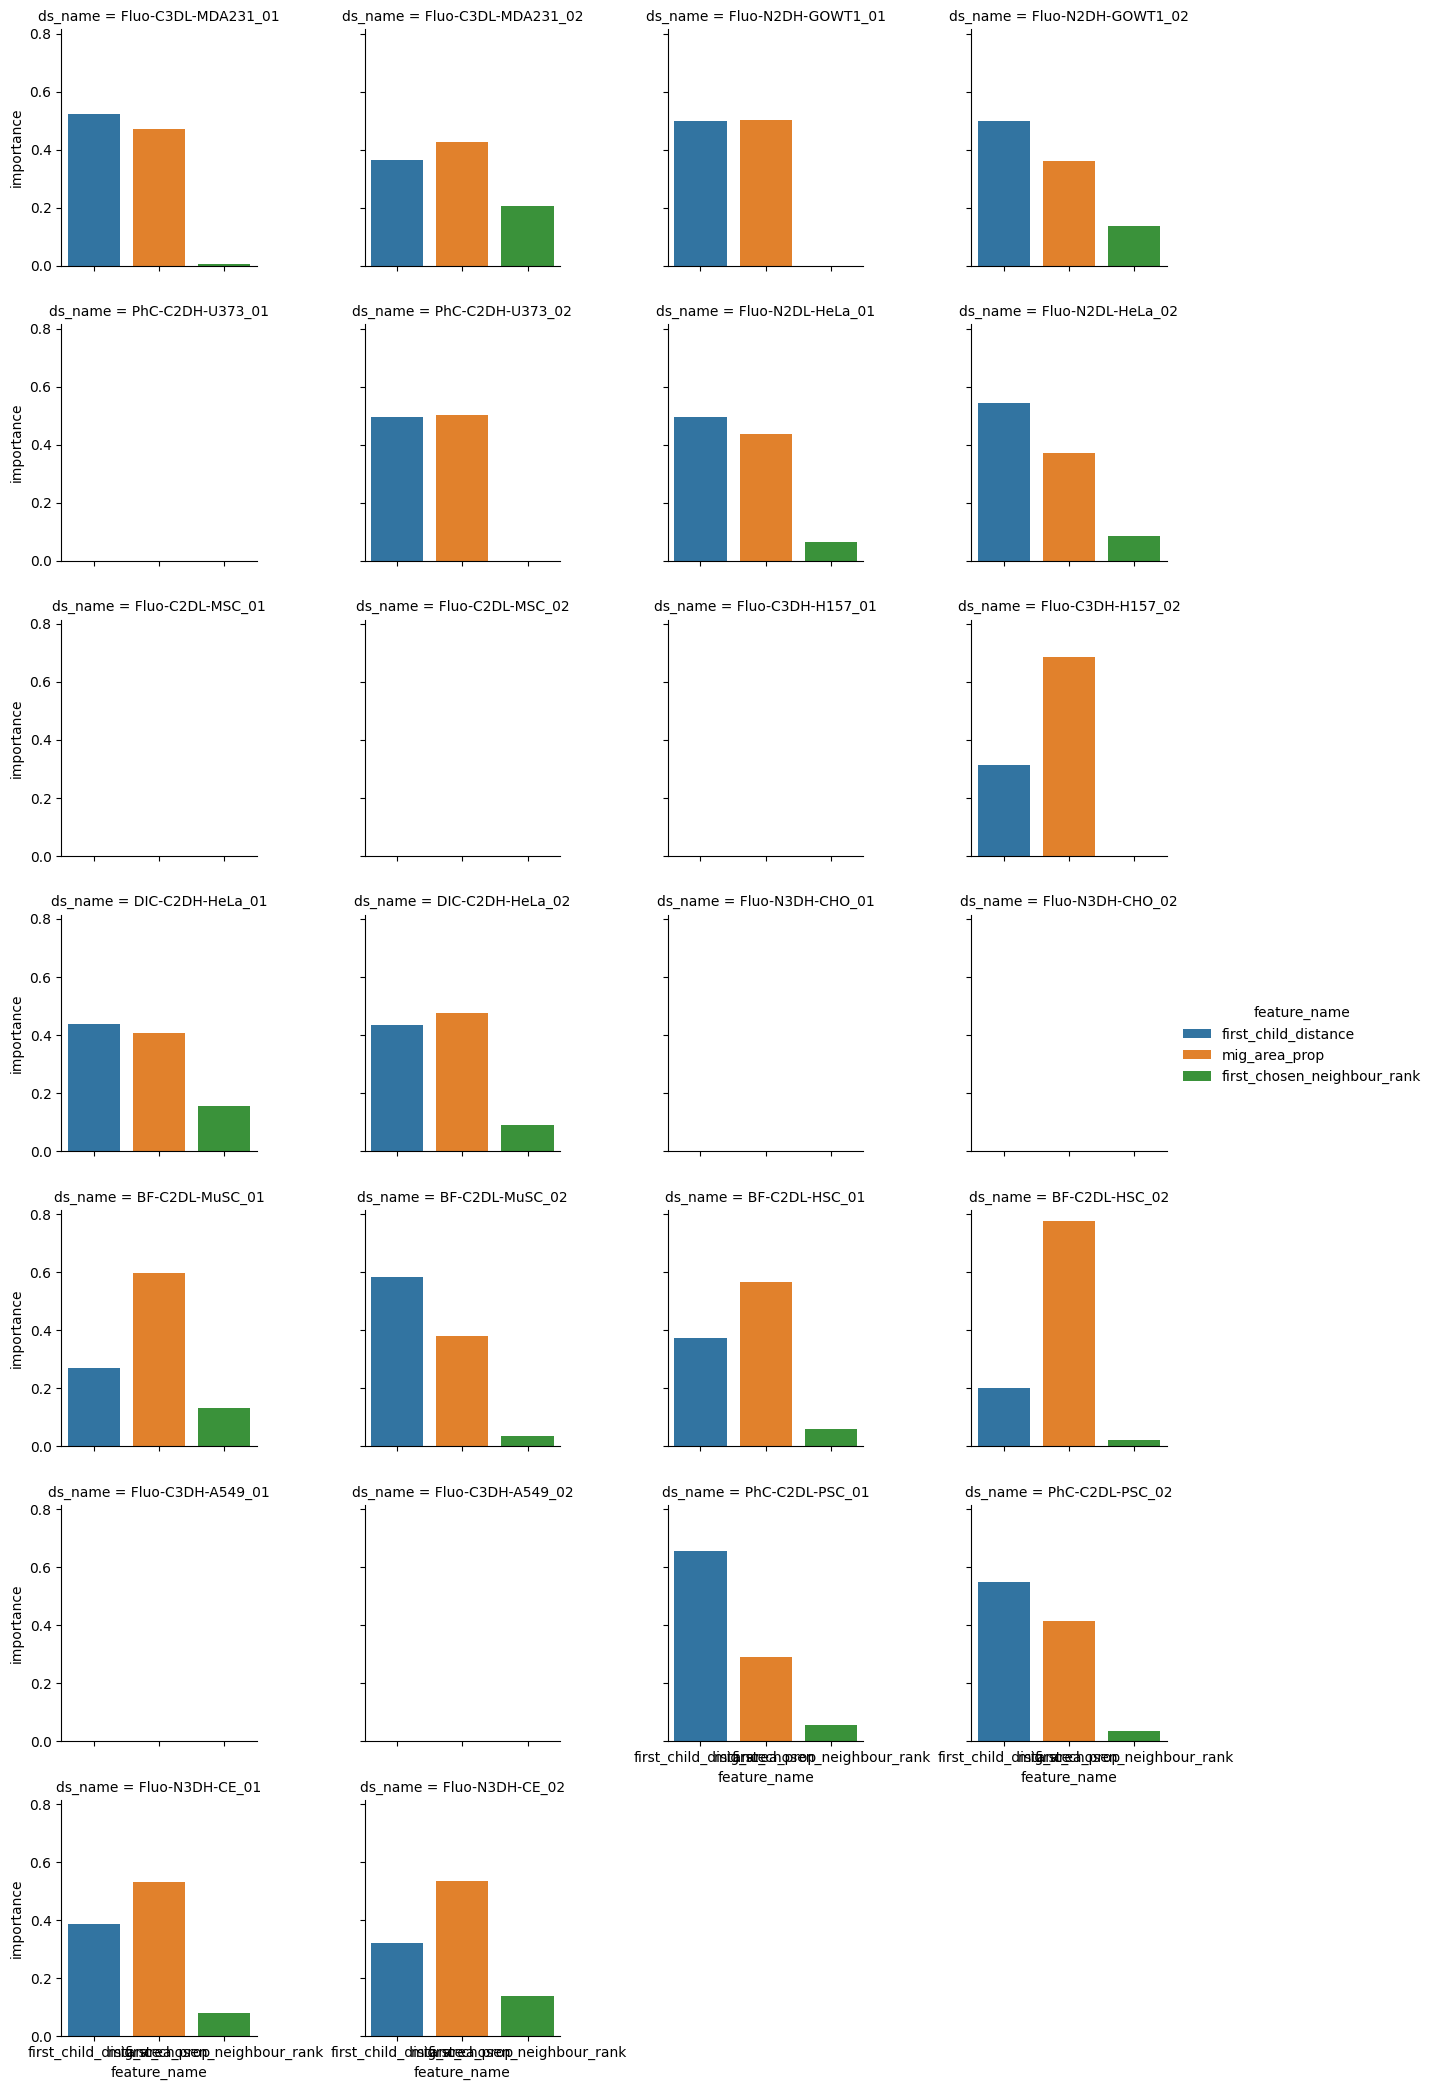

In [15]:
import seaborn as sns

grid = sns.FacetGrid(importance_df, col='ds_name', col_wrap=4, sharex=True, legend_out=True, hue='feature_name')
grid.map_dataframe(sns.barplot, x='feature_name', y='importance')
grid.add_legend()

In [11]:
from sklearn.cluster import k_means

k_mean_cols = columns_of_interest
kmeans_clustered = {}
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    data_df = all_migrations[all_migrations.ds_name == ds_name][columns_of_interest]
    if len(data_df) < 15:
        continue
    X = data_df.drop(columns=['mig_correct'])

    centroid, label, inertia = k_means(
        X, n_clusters=2, n_init="auto", random_state=0
    )
    data_df['cluster'] = label

    kmeans_clustered[ds_name] = data_df

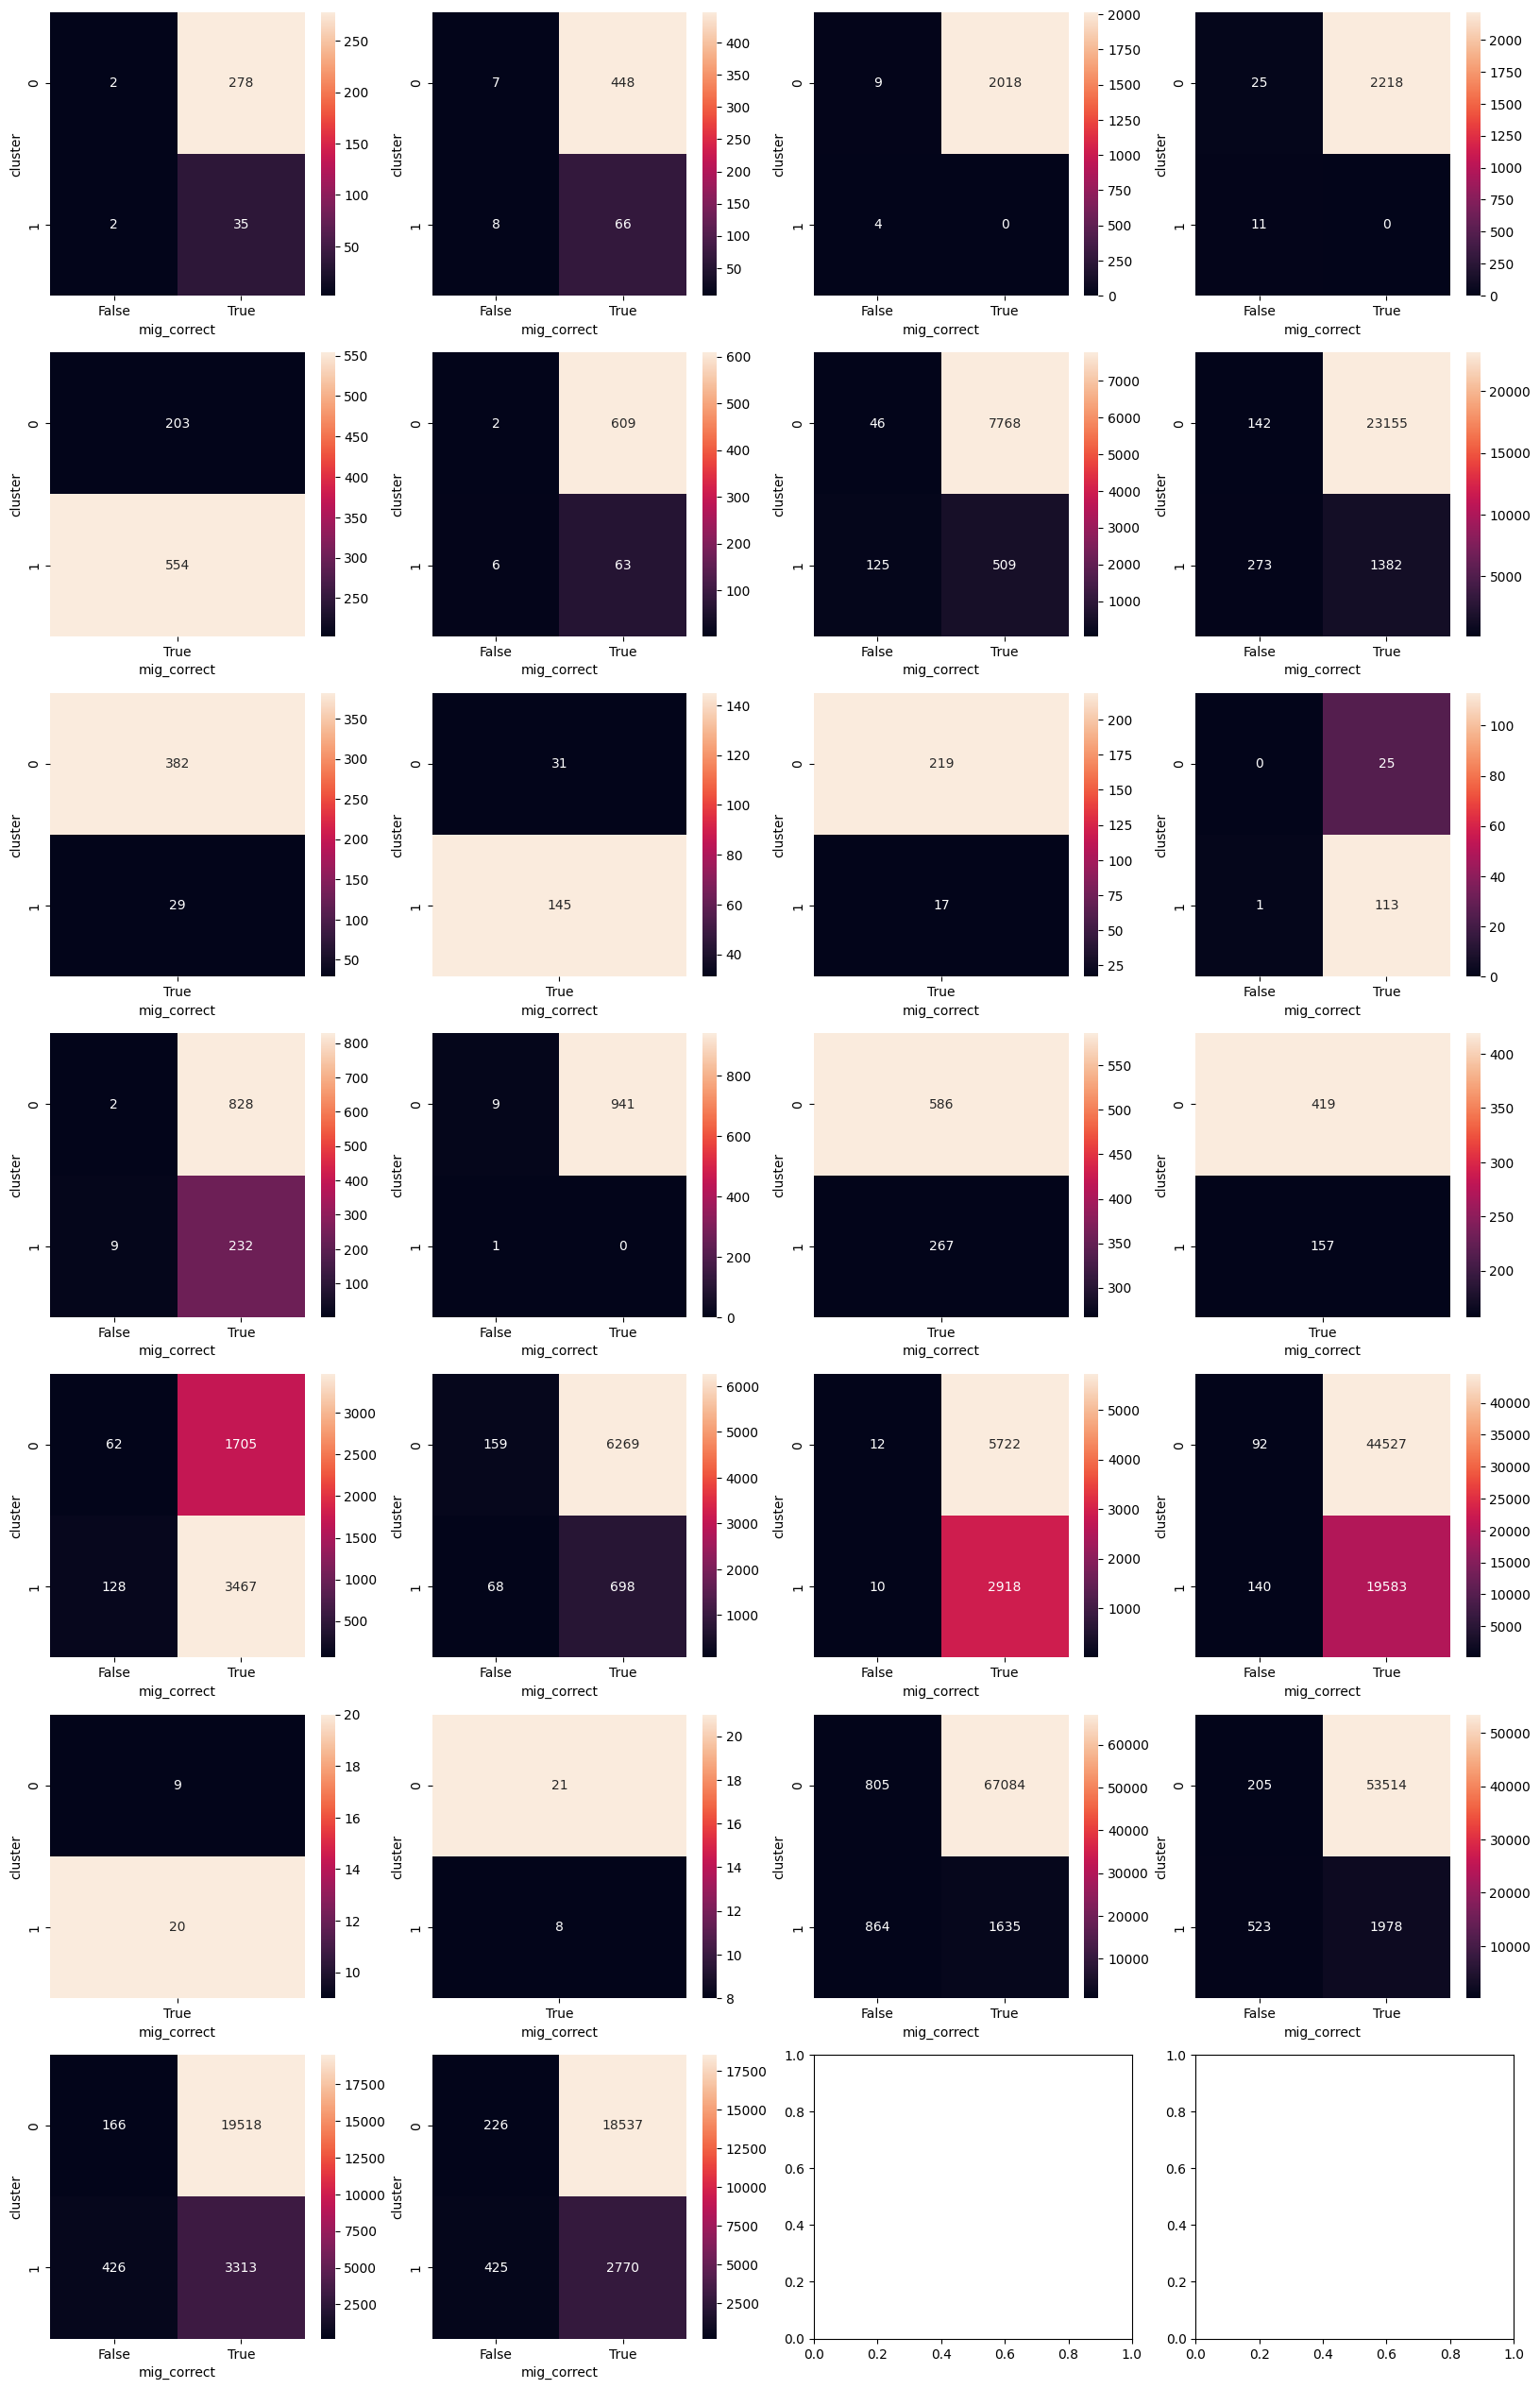

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(20,32), nrows=7, ncols=4)

targets = zip(kmeans_clustered.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    info = kmeans_clustered[key]
    cont_table = pd.crosstab(info.cluster, info.mig_correct)
    sns.heatmap(cont_table, annot=True, fmt='g', ax=ax); 
plt.show()